# Graph Analysis
### Modularity in graphs (or networks)
**Modularity** measures the quality of a network (or graph) partition into communities. 
- It compares the actual number of connections within communities to the expected number in a random network with the same degree distribution.

The standard formula for modularity is:
<br>$\large Q = \frac{1}{2m} \cdot \sum_{ij} (A_{ij} - \frac{k_i\cdot k_j}{2m}) \cdot \delta(cᵢ, cⱼ)$
<br>where:
- $A_{i,j}$ = Actual weight of edge between nodes $i$ and $j$ (1 if unweighted)
- $k_i$ = Degree of node $i$ (sum of edge weights connected to $i$)
- $k_j$ = Degree of node $j$
- $m$ = Total number of edges (or total edge weights)
- $\delta(c_i, c_j) =$ Kronecker delta: 1 if nodes $i$ and $j$ are in same community, else 0

High modularity means communities have more internal connections and fewer external connections than expected by chance. 
<br>The modualrity ranges from $-\frac{1}{2}$ to $1$, where:
- Q > 0: Community structure exists
- Q ≈ 0: No better than random
- Q < 0: Worse than random

<hr>

In the following, we compute **modularity** from the **adjacency matrix** of the graph, and test it by a weigthed graph and then an unweighted graph. As a bonus, we compute modularity from **adjacency list**, which is suitable for sparse graphs in terms of memory. We test the modularity from adjacency list by a friendship network. Finally, we display two cases of community partitions of the network and compute their modularity.

https://github.com/ostad-ai/Graph-Analysis
<br>Explanation in English :https://www.pinterest.com/HamedShahHosseini/graph-analysis/

In [1]:
# Import required modules
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
# Compute modularity for adjacency matrix and communities
def modularity(adj_matrix, communities):
    """
    Works for both weighted and unweighted graphs
    For unweighted: adj_matrix contains 0/1
    For weighted: adj_matrix contains weights
    """
    n = adj_matrix.shape[0]
    strengths = np.sum(adj_matrix, axis=1)  # For unweighted: this gives degrees
    W = np.sum(strengths) / 2  # For unweighted: W = m (number of edges)
    
    modularity = 0.0
    for i in range(n):
        for j in range(n):
            if communities[i] == communities[j]:
                actual = adj_matrix[i, j]
                expected = (strengths[i] * strengths[j]) / (2 * W)
                modularity += (actual - expected)
    
    return modularity / (2 * W)

In [3]:
# Example with weighted triangle
weighted_adj = np.array([
    [0, 2, 3],  # A
    [2, 0, 1],  # B
    [3, 1, 0]   # C
])

# Test different partitions
print("=== WEIGHTED TRIANGLE ===")
print("Adjacency matrix (weights):")
print(weighted_adj)

# All nodes in same community
communities_all = {0: 1, 1: 1, 2: 1}
Q_all = modularity(weighted_adj, communities_all)
print(f"\nAll nodes (A,B,C) in one community: Q = {Q_all:.4f}")

# A and B together, C separate  
communities_split = {0: 1, 1: 1, 2: 2}
Q_split = modularity(weighted_adj, communities_split)
print('-'*30)
print(f"Two communtiies (A,B) versus C: Q = {Q_split:.4f}")

=== WEIGHTED TRIANGLE ===
Adjacency matrix (weights):
[[0 2 3]
 [2 0 1]
 [3 1 0]]

All nodes (A,B,C) in one community: Q = -0.0000
------------------------------
Two communtiies (A,B) versus C: Q = -0.2222


In [4]:
# Example with unweighted graph
# Nodes: A=0, B=1, C=2, D=3, E=4, F=5
adj_matrix = np.array([
    [0, 1, 1, 1, 0, 0],  # A
    [1, 0, 1, 0, 0, 0],  # B  
    [1, 1, 0, 0, 0, 0],  # C
    [1, 0, 0, 0, 1, 1],  # D
    [0, 0, 0, 1, 0, 1],  # E
    [0, 0, 0, 1, 1, 0]   # F
])
# Community assignment
communities_1 = {
    0: 1,  # A in community 1
    1: 1,  # B in community 1  
    2: 1,  # C in community 1
    3: 2,  # D in community 2
    4: 2,  # E in community 2
    5: 2   # F in community 2
}
print('---Three cases of communities are checked for the graph--')
Q_1=modularity(adj_matrix,communities_1)
print(f"Case 1: Modularity of communities: {Q_1:.4f}")
#------------------
# Random community assignment
random_communities = {0: 1, 1: 2, 2: 1, 3: 2, 4: 1, 5: 2}
Q_random = modularity(adj_matrix, random_communities)
print(f"Case 2: Random assignment modularity: {Q_random:.4f}")
#------------------
# All nodes in same community
one_community = {i: 1 for i in range(6)}
Q_one = modularity(adj_matrix, one_community)
print(f"Case 3: Single community modularity: {Q_one:.4f}")

---Three cases of communities are checked for the graph--
Case 1: Modularity of communities: 0.3571
Case 2: Random assignment modularity: -0.2143
Case 3: Single community modularity: 0.0000


<hr style="height:3px;background-color:lightgreen">

## Bonus
#### Modularity from adjacency list

In [5]:
def modularity_adj_list(adj_list, communities, weighted=False):
    """
    Calculate modularity directly from adjacency list
    
    Parameters:
    - adj_list: dict where adj_list[i] = list of neighbors (unweighted)
                or adj_list[i] = dict of {neighbor: weight} (weighted)
    - communities: dict mapping node -> community id
    - weighted: boolean indicating if graph is weighted
    """
    nodes = list(adj_list.keys())
    
    # Calculate node strengths and total weight
    strengths = {}
    total_weight = 0.0
    
    for node, neighbors in adj_list.items():
        if weighted:
            # neighbors is a dict {neighbor: weight}
            strength = sum(neighbors.values())
            total_weight += strength
        else:
            # neighbors is a list of neighbor nodes
            strength = len(neighbors)
            total_weight += strength
        
        strengths[node] = strength
    
    W = total_weight / 2
    
    # Calculate modularity
    modularity = 0.0
    
    for node_i in nodes:
        comm_i = communities[node_i]
        
        for node_j in nodes:
            comm_j = communities[node_j]
            
            if comm_i == comm_j:
                # Get actual connection weight
                if weighted:
                    actual = adj_list[node_i].get(node_j, 0)
                else:
                    actual = 1 if node_j in adj_list[node_i] else 0
                
                # Calculate expected connection
                expected = (strengths[node_i] * strengths[node_j]) / (2 * W)
                modularity += (actual - expected)
    
    return modularity / (2 * W)

In [6]:
friendship_network = {
        'Alice': ['Bob', 'Charlie', 'Diana'],
        'Bob': ['Alice', 'Charlie', 'Eve'],
        'Charlie': ['Alice', 'Bob', 'Diana'],
        'Diana': ['Alice', 'Charlie', 'Frank'],
        'Eve': ['Bob', 'Frank', 'Grace'],
        'Frank': ['Diana', 'Eve', 'Grace'],
        'Grace': ['Eve', 'Frank', 'Henry'],
        'Henry': ['Grace']
    }
# Two friend circles
communities_social = {
        'Alice': 1, 'Bob': 1, 'Charlie': 1, 'Diana': 1,  # Friend group 1
        'Eve': 2, 'Frank': 2, 'Grace': 2, 'Henry': 2     # Friend group 2
    }
Q_social=modularity_adj_list(friendship_network,communities_social)
print(f"Social network modularity: {Q_social:.4f}")
#------------------------
# Try a different partition (mix the groups)
communities_mixed = {
        'Alice': 1, 'Bob': 1, 'Charlie': 1,
        'Diana': 2, 'Eve': 2, 'Frank': 2, 'Grace': 2, 'Henry': 2
    }
Q_mixed=modularity_adj_list(friendship_network,communities_mixed)
print('---By changing communities, modularity also changes---')
print(f"Mixed partition modularity: {Q_mixed:.4f}")

Social network modularity: 0.3140
---By changing communities, modularity also changes---
Mixed partition modularity: 0.2107


<hr style="height:3px;background-color:lightgreen">

## Extra
#### Helper functions to display the graphs with NetworkX

In [7]:
# Helper functions to draw the graphs and communities 
def networkx_to_adjacency(nx_graph):
    """
    Convert NetworkX graph to adjacency list
    """
    adj_list = {}
    for node in nx_graph.nodes():
        adj_list[node] = list(nx_graph.neighbors(node))
    return adj_list

#--------------------

def adjacency_to_networkx(adj_list):
    """
    Convert adjacency list to NetworkX graph for visualization
    """
    G = nx.Graph()
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    return G

def visualize_communities_adjacency(adj_list, communities, Q,title="Label Propagation Communities",pos=None):
    """Visualize graph with community coloring from adjacency list"""
    # Convert to NetworkX for visualization
    G = adjacency_to_networkx(adj_list)
    
    plt.figure(figsize=(12, 8))
    
    # Create position layout
    if pos is None:
        pos = nx.spring_layout(G, k=1, iterations=50)
    
    nodes=[]
    comms=defaultdict(list)
    for node, comm_id in communities.items():
        comms[comm_id].append(node)
        nodes.append(node)
        
    # Color nodes by community
    colors = plt.cm.Set3(np.linspace(0, 1, len(comms)))
    
    for i, (comm_id, nodes) in enumerate(comms.items()):
        nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                              node_color=[colors[i]],
                              node_size=2000, alpha=0.9)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=16)  
    
    plt.title(f"{title}\n{len(comms)} communities with modularity {Q:.4f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return pos

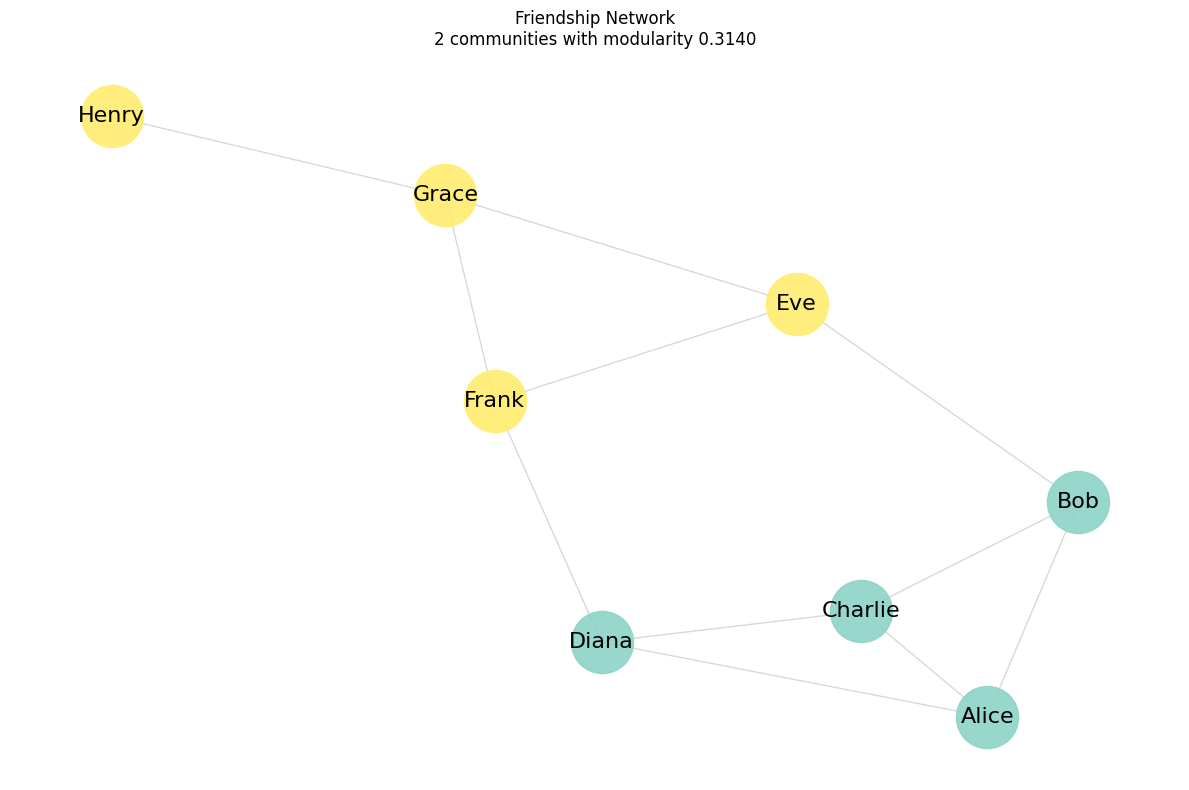

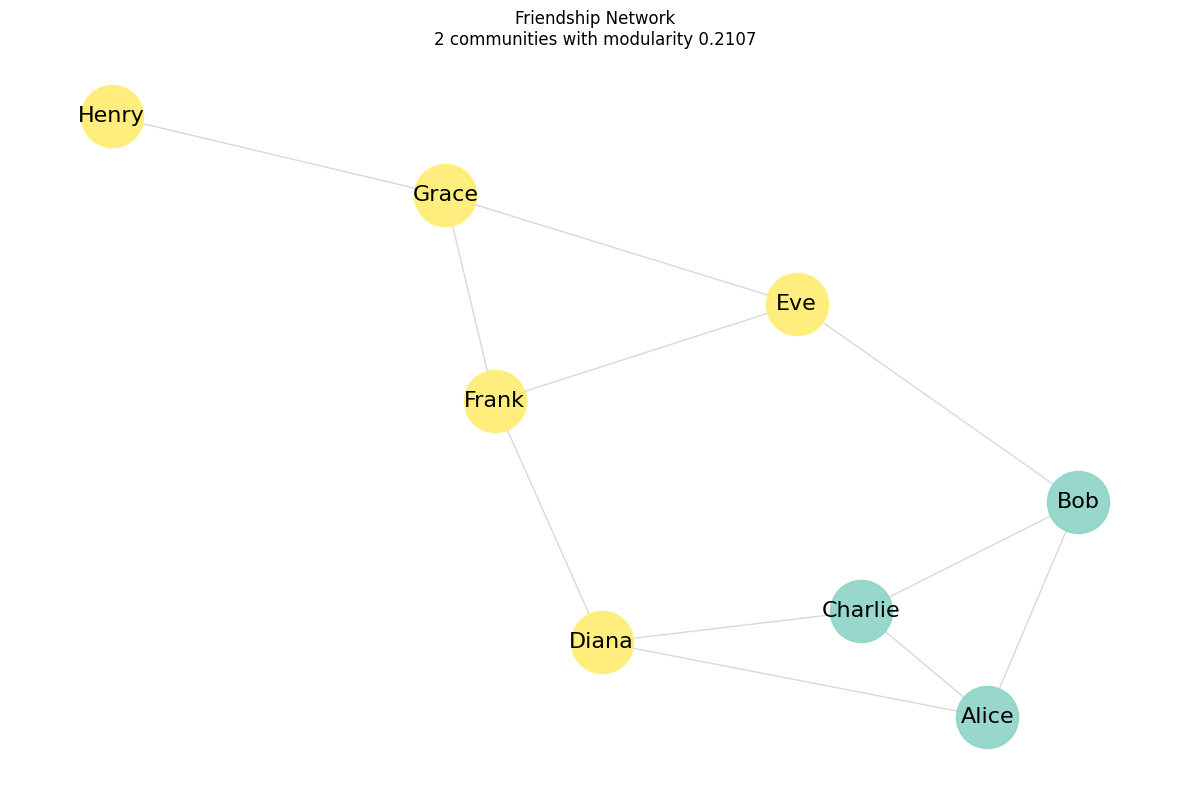

In [8]:
# Visualize the friednship network
pos=visualize_communities_adjacency(friendship_network, communities_social, Q_social,"Friendship Network")
_=visualize_communities_adjacency(friendship_network, communities_mixed, Q_mixed,"Friendship Network",pos)